### Ingest Voynich and reference texts

In [ ]:
from ingest_voynich import download_and_extract_eva
from get_coptic import download_coptic_texts

# Ingest voynich transcription
download_and_extract_eva()

# Ingest reference texts

# Syriac texts
%run get_syriac.py

# Coptic texts
START_URLS = [
    "https://data.copticscriptorium.org/texts/ap/",
    "https://data.copticscriptorium.org/texts/pistissophia/",
    "https://data.copticscriptorium.org/texts/magicalpapyri/",
    "https://data.copticscriptorium.org/texts/mysteriesjohn/"
]

download_coptic_texts(START_URLS)

# Greek and Hebrew texts
%run get_greek_and_hebrew.py

✔ Greek saved to data/reference_texts/alchemical_corpora/Greek\greek_sample.txt
✔ Hebrew saved to data/reference_texts/alchemical_corpora/Hebrew\hebrew_sample.txt


#### Pre-processing Voynich

In [ ]:
import json
from pathlib import Path
from pre_processing import preprocess_takahashi, chunk_records


# Gets voynich file and extracts the Takahashi transcription

file_path = Path(r"data\raw\voynich_eva.txt")
records = preprocess_takahashi(file_path, transcriber='H')
print(f"Extracted {len(records)} records for transcriber H.")

# Groups the transcriptions by sections. eg. Herbal, 

chunks = chunk_records(records, chunk_size=10)
print(f"Prepared {len(chunks)} chunks for embedding.")


# Save the sections to JSON Lines

records_out = Path("data/processed/voynich_records_H.jsonl")
records_out.parent.mkdir(parents=True, exist_ok=True)
with open(records_out, "w", encoding="utf-8") as fout:
    for rec in records:
        fout.write(json.dumps(rec, ensure_ascii=False) + "\n")
print(f"Saved records to {records_out}")


# Export chunks as a JSON array

chunks_out = Path("data/processed/voynich_chunks_H.json")
chunks_out.parent.mkdir(parents=True, exist_ok=True)
with open(chunks_out, "w", encoding="utf-8") as fout:
    json.dump(chunks, fout, ensure_ascii=False, indent=2)
print(f"Saved chunks to {chunks_out}")

# Show first chunk for sanity-check
print(json.dumps(chunks[0], indent=2, ensure_ascii=False))


#### Processing texts

In [4]:
%run clean_greek_file.py

%run process_greek.py

%run process_coptic.py

%run process_syriac.py

%run process_hebrew.py

Processed file saved to: data/reference_texts/alchemical_corpora/Greek/language_processed\Hermetica_clean.txt
Saved 170 chunks to data/reference_texts/alchemical_corpora/Greek/language_processed/Hermetica.jsonl
Found 191 .txt files under 'data/reference_texts/alchemical_corpora/Coptic'
Wrote 191 records to 'coptic_corpus.jsonl'
Found 556 .txt files under 'data/reference_texts/alchemical_corpora/Syriac'
Wrote 556 records to 'syriac_corpus.jsonl'
Saved 27 chunks into "data\reference_texts\alchemical_corpora\Hebrew\language_processed\SeferYetzira.jsonl"


In [5]:
from build_language_json_chunks import jsonl_to_chunked_json

BASE_URL = "data/reference_texts/alchemical_corpora/"
language_dict ={'Coptic':'language_processed/coptic_corpus.jsonl', 
                'Greek':'language_processed/Hermetica.jsonl',
                'Hebrew':'language_processed/SeferYetzira.jsonl',
                'Syriac':'language_processed/syriac_corpus.jsonl'}


for key, value in language_dict.items():
    jsonl_to_chunked_json(
    input_path=f"{BASE_URL}/{key}/{value}",
    output_path=f"{BASE_URL}/{key}/{value}",
    chunk_size=5,
    max_chars=1000
)    


Saved 168 chunked records into 'data/reference_texts/alchemical_corpora//Coptic/language_processed/coptic_corpus.jsonl'
Saved 82 chunked records into 'data/reference_texts/alchemical_corpora//Greek/language_processed/Hermetica.jsonl'
Saved 22 chunked records into 'data/reference_texts/alchemical_corpora//Hebrew/language_processed/SeferYetzira.jsonl'
Saved 4566 chunked records into 'data/reference_texts/alchemical_corpora//Syriac/language_processed/syriac_corpus.jsonl'


#### Start embedding container

In [4]:
#docker run --rm -it --gpus all --ipc=host --ulimit memlock=-1 --ulimit stack=67108864 --platform linux/amd64 -e NVIDIA_VISIBLE_DEVICES=all -p 8000:8000 voynich-embed:cuda12-1
%run start_embedding_container.py


Starting container...

Container logs:

== PyTorch ==

NVIDIA Release 24.02 (build 82611821)
PyTorch Version 2.3.0a0+ebedce2
Container image Copyright (c) 2024, NVIDIA CORPORATION & AFFILIATES. All rights reserved.
Copyright (c) 2014-2024 Facebook Inc.
Copyright (c) 2011-2014 Idiap Research Institute (Ronan Collobert)
Copyright (c) 2012-2014 Deepmind Technologies    (Koray Kavukcuoglu)
Copyright (c) 2011-2012 NEC Laboratories America (Koray Kavukcuoglu)
Copyright (c) 2011-2013 NYU                      (Clement Farabet)
Copyright (c) 2006-2010 NEC Laboratories America (Ronan Collobert, Leon Bottou, Iain Melvin, Jason Weston)
Copyright (c) 2006      Idiap Research Institute (Samy Bengio)
Copyright (c) 2001-2004 Idiap Research Institute (Ronan Collobert, Samy Bengio, Johnny Mariethoz)
Copyright (c) 2015      Google Inc.
Copyright (c) 2015      Yangqing Jia
Copyright (c) 2013-2016 The Caffe contributors
All rights reserved.

Various files include modifications (c) NVIDIA CORPORATION & AFFI

#### Create embeddings and save it

In [6]:
from embed_client import EmbedderClient
from embed_save import save_records_with_embeddings
import json

texts_to_embed = {
    "data/reference_texts/alchemical_corpora/Coptic/language_processed":"data/reference_texts/alchemical_corpora/Coptic/language_processed/coptic_chunks.json",
    "data/embeddings":"./data/processed/voynich_chunks_H.json",
    "data/reference_texts/alchemical_corpora/Greek/language_processed":"data/reference_texts/alchemical_corpora/Greek/language_processed/Hermetica.json",
    "data/reference_texts/alchemical_corpora/Hebrew/language_processed":"data/reference_texts/alchemical_corpora/Hebrew/language_processed/SeferYetzira.json",
    "data/reference_texts/alchemical_corpora/Syriac/language_processed":"data/reference_texts/alchemical_corpora/Syriac/language_processed/syriac_corpus.json"
}

client = EmbedderClient("http://localhost:8000/embed")

for folder, file in texts_to_embed.items():
        
    with open(file, 'r', encoding='utf-8') as f:
        records = json.load(f)

    texts = [rec["text"] for rec in records]
    vectors = client.embed_texts(texts)

    # attach back to records
    for rec, vec in zip(records, vectors):
        rec["embedding"] = vec

    prefix = file.split('/')[-1].split('.')[0]
    save_records_with_embeddings(records, output_dir=folder, prefix=prefix )

Saved 168 records to data\reference_texts\alchemical_corpora\Coptic\language_processed\coptic_chunks_20250801T110504Z.jsonl
Saved 631 records to data\embeddings\voynich_chunks_H_20250801T110506Z.jsonl
Saved 82 records to data\reference_texts\alchemical_corpora\Greek\language_processed\Hermetica_20250801T110507Z.jsonl
Saved 23 records to data\reference_texts\alchemical_corpora\Hebrew\language_processed\SeferYetzira_20250801T110507Z.jsonl
Saved 4566 records to data\reference_texts\alchemical_corpora\Syriac\language_processed\syriac_corpus_20250801T110536Z.jsonl


#### Plotting Voynich Embedding Grouped by Sections using PCA

Loaded 631 records for Voynich
Chunk Section Distribution:
- Text: 25 chunks
- Herbal: 230 chunks
- Cosmological: 36 chunks
- Astronomical: 27 chunks
- Zodiac: 40 chunks
- Biological: 102 chunks
- Pharmaceutical: 52 chunks
- Stars: 119 chunks


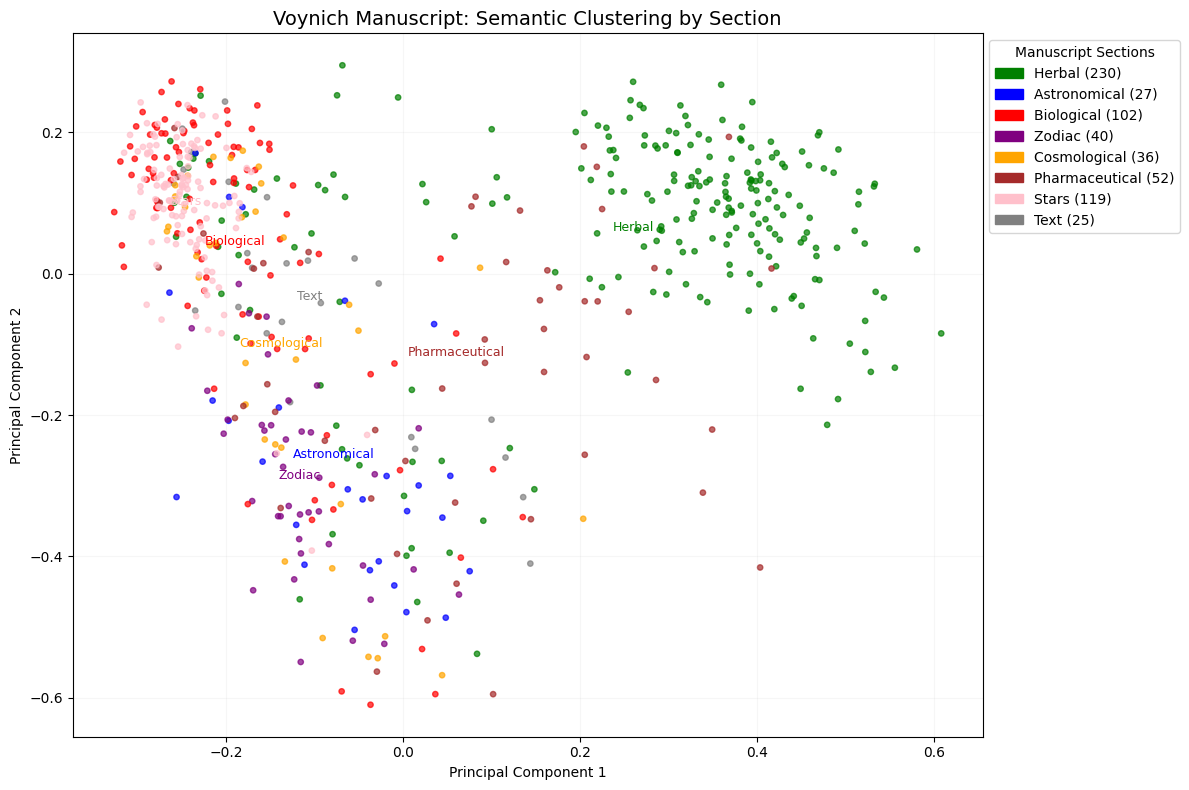

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import matplotlib.patches as mpatches
from collections import Counter
from utilities import load_language_embeddings

path = r'data\embeddings\voynich_chunks_H_20250801T110506Z.jsonl'
    
records= load_language_embeddings(path, language_name='Voynich')

# Build embeddings array
X = np.array([rec["embedding"] for rec in records])

# PCA for 2D projection
X2d = PCA(n_components=2).fit_transform(X)

# Define section colors
section_colors = {
    'Herbal': 'green',
    'Astronomical': 'blue',
    'Biological': 'red',
    'Zodiac': 'purple',
    'Cosmological': 'orange',
    'Pharmaceutical': 'brown',
    'Stars': 'pink',
    'Text': 'gray',
    'Unknown': 'silver'
}

# Create color array by extracting section from metadata
colors = []
section_list = []  # For diagnostics

for chunk in records:
    # Get the most common section in this chunk
    chunk_sections = [item.get('section', 'Unknown') for item in chunk['metadata']]
    most_common_section = Counter(chunk_sections).most_common(1)[0][0]
    
    colors.append(section_colors.get(most_common_section, 'silver'))
    section_list.append(most_common_section)

# Diagnostic: Print section distribution
section_counts = Counter(section_list)
print("Chunk Section Distribution:")
for section, count in section_counts.items():
    print(f"- {section}: {count} chunks")

# Create the plot
plt.figure(figsize=(12, 8))
scatter = plt.scatter(X2d[:,0], X2d[:,1], c=colors, s=15, alpha=0.7)

# Create custom legend
legend_handles = []
for section, color in section_colors.items():
    if section in section_counts:  # Only include sections that exist in data
        legend_handles.append(mpatches.Patch(color=color, label=f"{section} ({section_counts[section]})"))

plt.legend(handles=legend_handles, title="Manuscript Sections", 
           loc='upper left', bbox_to_anchor=(1, 1))

plt.title("Voynich Manuscript: Semantic Clustering by Section", fontsize=14)
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.grid(alpha=0.1)

# Add section-specific annotations if desired
for section, color in section_colors.items():
    if section in section_counts:
        section_indices = [i for i, s in enumerate(section_list) if s == section]
        if section_indices:
            plt.annotate(section, 
                         (np.mean(X2d[section_indices, 0]), np.mean(X2d[section_indices, 1])),
                         fontsize=9, ha='center', color=color)

plt.tight_layout()
plt.savefig('voynich_section_clusters.png', dpi=300, bbox_inches='tight')
plt.show()

#### Plotting Voynich Sections Correlation Heat Map

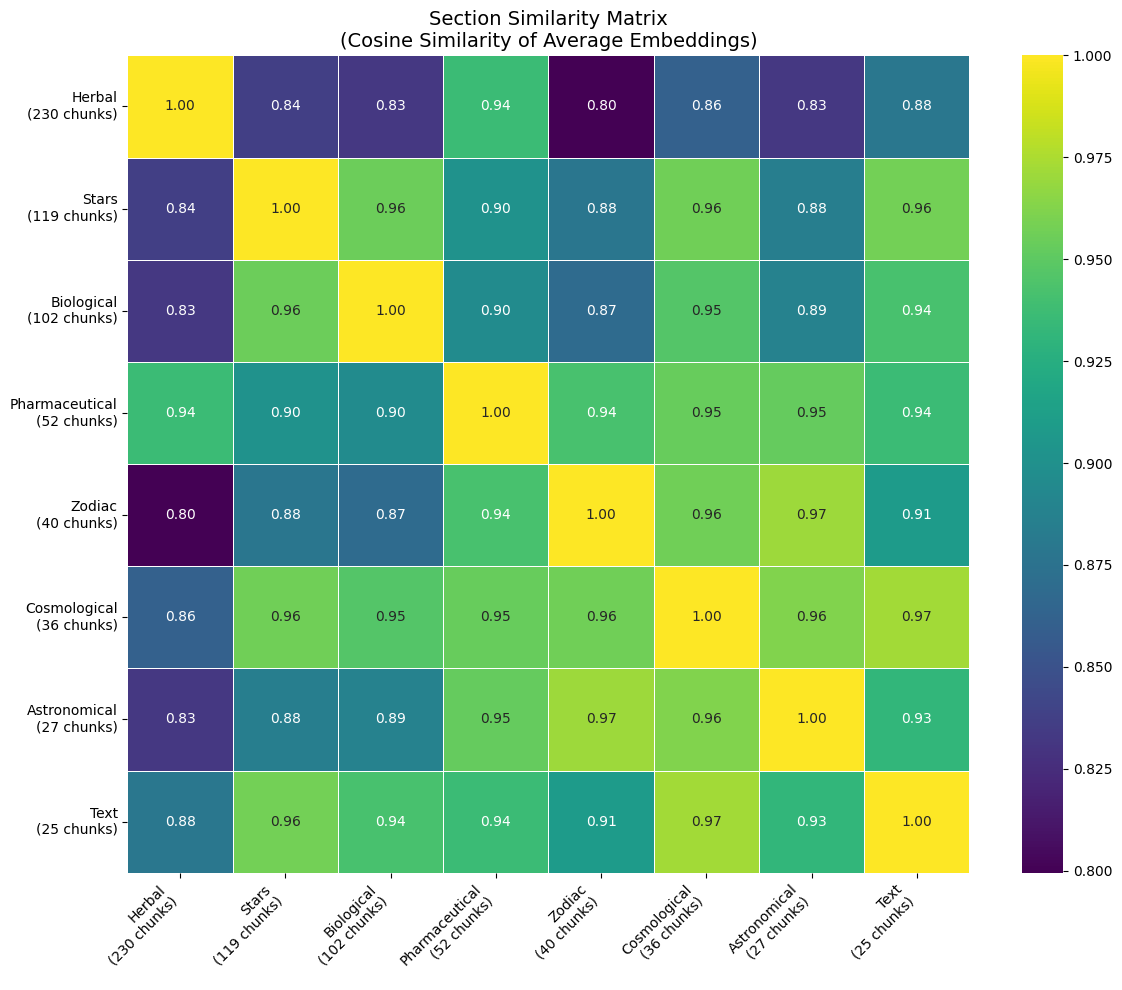

In [3]:
import seaborn as sns
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt

# 1. Prepare section embeddings
section_embeddings = {}
section_counts = {}

for chunk in records:
    # Get most common section in chunk
    chunk_sections = [m.get('section', 'Unknown') for m in chunk['metadata']]
    section = max(set(chunk_sections), key=chunk_sections.count)
    
    # Initialize storage
    if section not in section_embeddings:
        section_embeddings[section] = []
        section_counts[section] = 0
        
    # Add embedding and increment count
    section_embeddings[section].append(chunk["embedding"])
    section_counts[section] += 1

# 2. Compute average embeddings per section
avg_embeddings = {}
for section, embeds in section_embeddings.items():
    avg_embeddings[section] = np.mean(embeds, axis=0)

# 3. Create ordered section list (by frequency)
ordered_sections = sorted(section_counts.keys(), 
                         key=lambda x: section_counts[x], 
                         reverse=True)

# 4. Compute similarity matrix
matrix = []
for section1 in ordered_sections:
    row = []
    for section2 in ordered_sections:
        # Cosine similarity between avg embeddings
        sim = cosine_similarity(
            [avg_embeddings[section1]], 
            [avg_embeddings[section2]]
        )[0][0]
        row.append(sim)
    matrix.append(row)

# 5. Create heatmap
plt.figure(figsize=(12, 10))
ax = sns.heatmap(
    matrix,
    annot=True,
    fmt=".2f",
    cmap="viridis",
    xticklabels=ordered_sections,
    yticklabels=ordered_sections,
    linewidths=0.5
)

# Add counts to labels
new_labels = [
    f"{sec}\n({section_counts[sec]} chunks)" 
    for sec in ordered_sections
]
ax.set_xticklabels(new_labels, rotation=45, ha='right')
ax.set_yticklabels(new_labels, rotation=0)

plt.title("Section Similarity Matrix\n(Cosine Similarity of Average Embeddings)", fontsize=14)
plt.tight_layout()
plt.savefig('section_similarity_heatmap.png', dpi=300, bbox_inches='tight')
plt.show()

#### Plotting Languages and Voynich Embeddings

===== Loading Data =====
Loaded 631 records from Voynich
Loaded 97 records from Coptic
Loaded 82 records from Greek
Loaded 23 records from Hebrew
Loaded 4566 records from Syriac

===== Preparing Data =====

Label distribution:
- Syriac: 4566
- Herbal: 230
- Stars: 119
- Biological: 102
- Coptic: 97
- Greek: 82
- Pharmaceutical: 52
- Zodiac: 40
- Cosmological: 36
- Astronomical: 27
- Text: 25
- Hebrew: 23
PCA projection successful

===== Creating Visualization =====


C:\Users\RDPcolthrane\AppData\Local\Temp\ipykernel_37292\3926451492.py:275: UserWarning: Glyph 78222 (\N{EGYPTIAN HIEROGLYPH I006}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\RDPcolthrane\AppData\Local\Temp\ipykernel_37292\3926451492.py:276: UserWarning: Glyph 78222 (\N{EGYPTIAN HIEROGLYPH I006}) missing from font(s) DejaVu Sans.
  plt.savefig(OUTPUT_FILENAME, dpi=PLOT_DPI, bbox_inches='tight')


Plot saved as 'voynich_language_comparison.png'


c:\Users\RDPcolthrane\OneDrive\Documentos\Empresa\challenges\Voynich\voynich-challenge\.voynich-note\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 78222 (\N{EGYPTIAN HIEROGLYPH I006}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


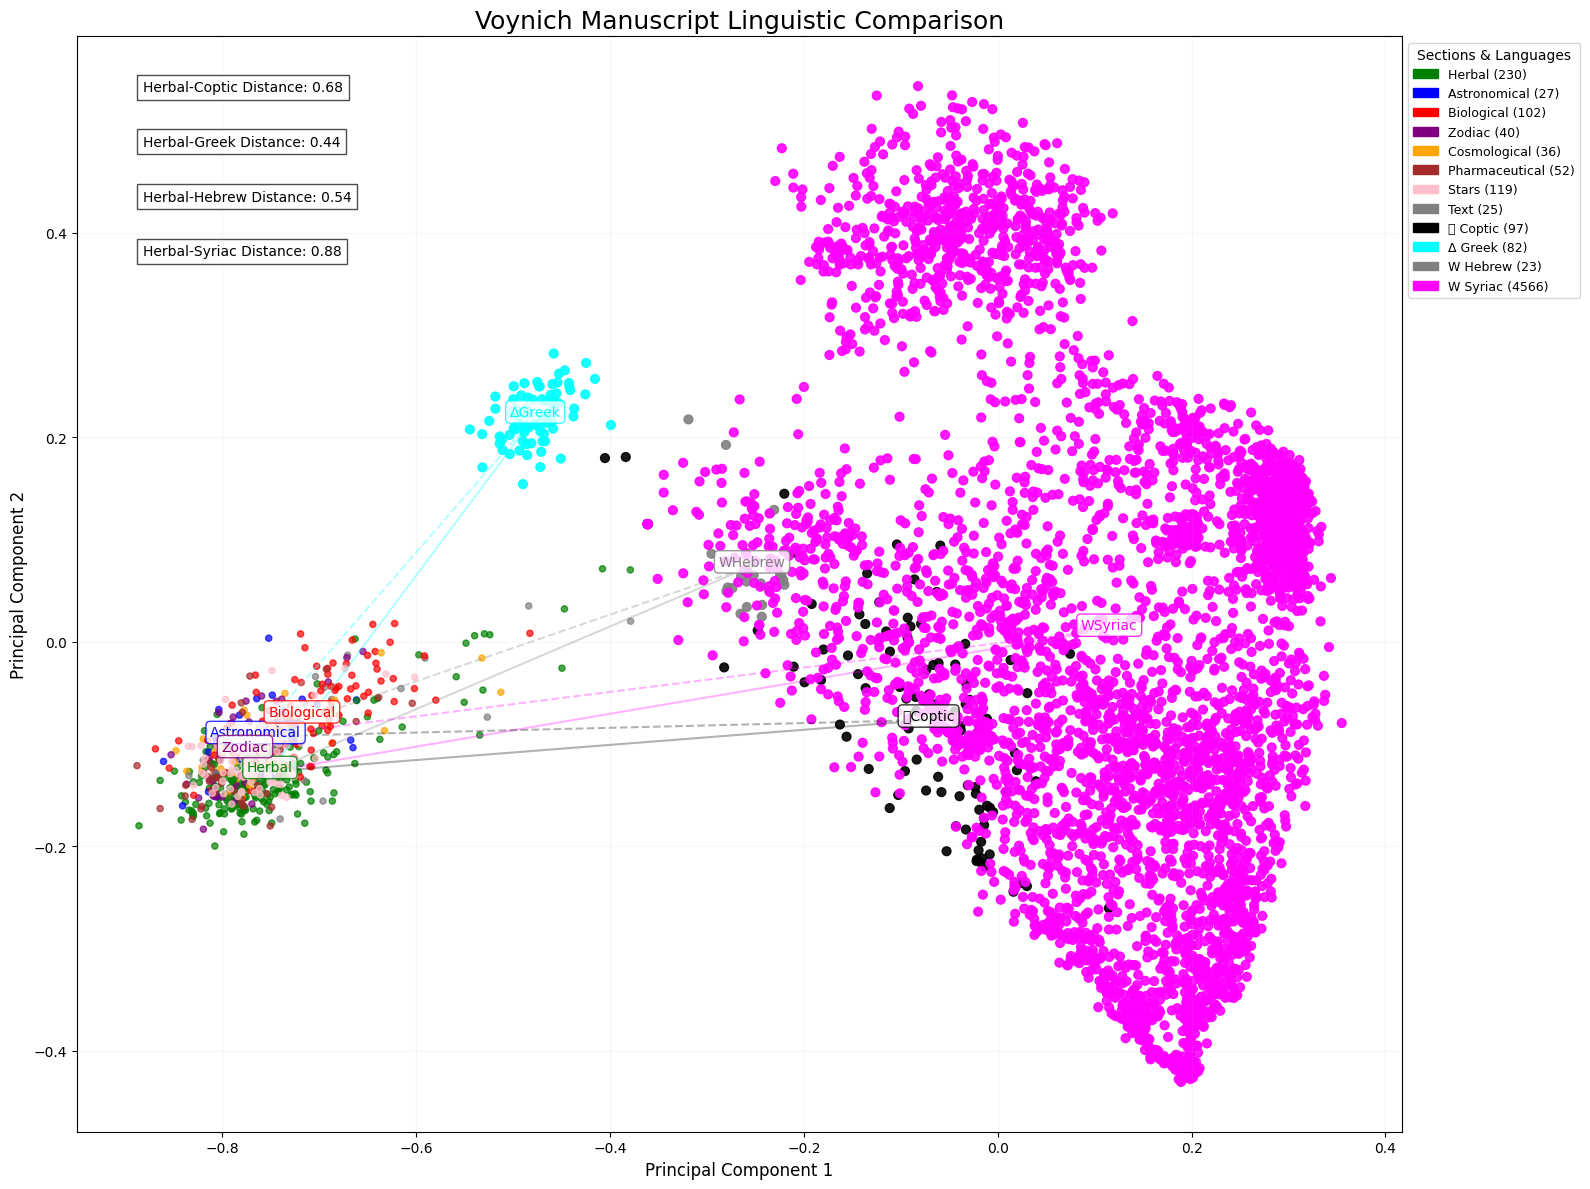


===== Distance Analysis =====
Herbal to Coptic: 0.6814 (lower = more similar)
Herbal to Greek: 0.4425 (lower = more similar)
Herbal to Hebrew: 0.5364 (lower = more similar)
Herbal to Syriac: 0.8769 (lower = more similar)
Astronomical to Coptic: 0.6945
Astronomical to Greek: 0.4261
Astronomical to Hebrew: 0.5387
Astronomical to Syriac: 0.8869

===== Closest Voynich Sections to Languages =====

Closest Voynich sections to Coptic:
  - Text (distance: 0.3161)
  - Herbal (distance: 0.3314)
  - Herbal (distance: 0.3586)

Closest Voynich sections to Greek:
  - Herbal (distance: 0.2165)
  - Herbal (distance: 0.2259)
  - Text (distance: 0.2481)

Closest Voynich sections to Hebrew:
  - Herbal (distance: 0.1546)
  - Text (distance: 0.1605)
  - Herbal (distance: 0.1833)

Closest Voynich sections to Syriac:
  - Text (distance: 0.5940)
  - Herbal (distance: 0.6176)
  - Herbal (distance: 0.6421)


In [6]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import matplotlib.patches as mpatches
from collections import Counter
import json
import re
import os

# =====================
# CONFIGURATION SECTION
# =====================
# Voynich configuration

VOYNICH_PATH = r'data\embeddings\voynich_chunks_H_20250801T110506Z.jsonl'

# Language configuration dictionary
# Add new languages here with their paths and display properties
LANGUAGES_CONFIG = {
    "Coptic": {
        "path": r"data\reference_texts\alchemical_corpora\Coptic\language_processed\coptic_chunks_20250727T150738Z.jsonl",
        "color": "black",
        "symbol": "𓆎"  # Coptic cross
    },
    "Greek": {
        "path": r"data\reference_texts\alchemical_corpora\Greek\language_processed\Hermetica_20250727T152401Z.jsonl",
        "color": "cyan",
        "symbol": "Δ"   # Greek Delta
    },
    
    "Hebrew": {
         "path": r"data\reference_texts\alchemical_corpora\Hebrew\language_processed\SeferYetzira_20250727T155303Z.jsonl",
         "color": "gray",
         "symbol": "W"
    },
    "Syriac": {
        "path": r"data\reference_texts\alchemical_corpora\Syriac\language_processed\syriac_corpus_20250727T161033Z.jsonl",
        "color": "magenta",
        "symbol": "W"
    }

}

# Voynich section colors
SECTION_COLORS = {
    'Herbal': 'green',
    'Astronomical': 'blue',
    'Biological': 'red',
    'Zodiac': 'purple',
    'Cosmological': 'orange',
    'Pharmaceutical': 'brown',
    'Stars': 'pink',
    'Text': 'gray',
    'Unknown': 'silver'
}

# Zodiac mapping
ZODIAC_MAP = {
    '1': 'Aries', '2': 'Taurus', '3': 'Gemini', '4': 'Cancer',
    '5': 'Leo', '6': 'Virgo', '7': 'Libra', '8': 'Scorpio',
    '9': 'Sagittarius', '10': 'Capricorn', '11': 'Aquarius', '12': 'Pisces'
}

# Plot settings
PLOT_SIZE = (16, 12)
PLOT_DPI = 300
OUTPUT_FILENAME = "voynich_language_comparison.png"

# =====================
# FUNCTION DEFINITIONS
# =====================
def load_embeddings(path, source_name):
    """Load embeddings from JSONL file with error handling"""
    records = []
    try:
        if os.path.exists(path):
            with open(path, "r", encoding="utf-8") as f:
                for line in f:
                    try:
                        records.append(json.loads(line))
                    except json.JSONDecodeError:
                        print(f"  JSON decode error in {path}")
            print(f"Loaded {len(records)} records from {source_name}")
        else:
            print(f"File not found: {path}")
    except Exception as e:
        print(f"Error loading {source_name}: {str(e)}")
    return records

def extract_section(metadata):
    """Safely extract section from Voynich metadata"""
    if not isinstance(metadata, list):
        return 'Unknown'
    
    sections = []
    for item in metadata:
        if isinstance(item, dict):
            section = item.get('section')
            if section and isinstance(section, str):
                sections.append(section)
    
    return Counter(sections).most_common(1)[0][0] if sections else 'Unknown'

def clean_labels(labels):
    """Clean and normalize labels, handling zodiac numbers"""
    cleaned = []
    for label in labels:
        if isinstance(label, str) and label.isdigit():
            cleaned.append(ZODIAC_MAP.get(label, 'Zodiac'))
        elif isinstance(label, str):
            # Normalize whitespace and case
            clean_label = re.sub(r'\s+', ' ', label).strip()
            cleaned.append(clean_label)
        else:
            cleaned.append('Unknown')
    return cleaned

def annotate_group(ax, label, color, positions, symbol=""):
    """Annotate a group of points on the plot"""
    indices = [i for i, lbl in enumerate(cleaned_labels) if lbl == label]
    if indices:
        center = np.mean(positions[indices], axis=0)
        ax.annotate(f"{symbol}{label}", center,
                    fontsize=10, ha='center', color=color,
                    bbox=dict(boxstyle="round,pad=0.3", fc='white', ec=color, alpha=0.8))
        return center
    return None

# =====================
# MAIN PROCESSING
# =====================
print("===== Loading Data =====")
# Load Voynich data
voynich_records = load_embeddings(VOYNICH_PATH, "Voynich")

# Load reference languages
reference_records = {}
for lang, config in LANGUAGES_CONFIG.items():
    records = load_embeddings(config["path"], lang)
    reference_records[lang] = records

print("\n===== Preparing Data =====")
# Combine all datasets
all_records = voynich_records.copy()
all_labels = []
all_sources = []
all_embeddings = []

# Process Voynich records
for chunk in voynich_records:
    try:
        section = extract_section(chunk.get('metadata', []))
        all_embeddings.append(chunk["embedding"])
        all_labels.append(section)
        all_sources.append('Voynich')
    except Exception as e:
        print(f"Skipping Voynich chunk: {str(e)}")

# Process reference languages
for lang, records in reference_records.items():
    for record in records:
        try:
            all_embeddings.append(record["embedding"])
            all_labels.append(lang)
            all_sources.append(lang)
            all_records.append(record)
        except Exception as e:
            print(f"Skipping {lang} record: {str(e)}")

# Clean and normalize labels
cleaned_labels = clean_labels(all_labels)

# Diagnostic: Print label distribution
label_counter = Counter(cleaned_labels)
print("\nLabel distribution:")
for label, count in label_counter.most_common():
    print(f"- {label}: {count}")

# Create PCA projection
if not all_embeddings:
    print("No embeddings found - exiting")
    exit()

try:
    X = np.array(all_embeddings)
    X2d = PCA(n_components=2).fit_transform(X)
    print("PCA projection successful")
except Exception as e:
    print(f"Error during PCA: {str(e)}")
    exit()

print("\n===== Creating Visualization =====")
# Create unified color map
color_map = SECTION_COLORS.copy()
for lang, config in LANGUAGES_CONFIG.items():
    color_map[lang] = config["color"]

# Assign colors
colors = []
for label in cleaned_labels:
    colors.append(color_map.get(label, 'silver'))

# Assign sizes and alphas (reference languages are larger)
sizes = [20 if source == 'Voynich' else 40 for source in all_sources]
alphas = [0.7 if source == 'Voynich' else 0.9 for source in all_sources]

# Create figure
fig, ax = plt.subplots(figsize=PLOT_SIZE)
scatter = ax.scatter(X2d[:,0], X2d[:,1], c=colors, s=sizes, alpha=alphas)

# Create legend
legend_handles = []
for label, color in color_map.items():
    count = cleaned_labels.count(label)
    if count > 0:
        # Add symbols for configured languages
        symbol = ""
        if label in LANGUAGES_CONFIG:
            symbol = LANGUAGES_CONFIG[label].get("symbol", "") + " "
        
        legend_handles.append(mpatches.Patch(
            color=color, 
            label=f"{symbol}{label} ({count})"
        ))

# Add legend for unknown items if any
unknown_count = cleaned_labels.count('Unknown')
if unknown_count > 0:
    legend_handles.append(mpatches.Patch(
        color='silver', 
        label=f"Unknown ({unknown_count})"
    ))

ax.legend(handles=legend_handles, title="Sections & Languages", 
          loc='upper left', bbox_to_anchor=(1, 1),
          fontsize=9)

# Add annotations
centers = {}
for lang in LANGUAGES_CONFIG:
    config = LANGUAGES_CONFIG[lang]
    centers[lang] = annotate_group(ax, lang, config["color"], X2d, config.get("symbol", ""))

# Annotate key Voynich sections
for section in ['Herbal', 'Astronomical', 'Biological', 'Zodiac']:
    centers[section] = annotate_group(ax, section, SECTION_COLORS.get(section, 'silver'), X2d)

# Draw connections between Voynich sections and languages
for section in ['Herbal', 'Astronomical']:
    if section in centers:
        for lang in LANGUAGES_CONFIG:
            if lang in centers:
                linestyle = '-' if section == 'Herbal' else '--'
                ax.plot([centers[section][0], centers[lang][0]], 
                         [centers[section][1], centers[lang][1]], 
                         color=color_map[lang], 
                         linestyle=linestyle, alpha=0.3, linewidth=1.5)

# Add distance metrics
if 'Herbal' in centers:
    for lang in LANGUAGES_CONFIG:
        if lang in centers:
            dist = np.linalg.norm(centers['Herbal'] - centers[lang])
            ax.text(0.05, 0.95 - (0.05 * list(LANGUAGES_CONFIG.keys()).index(lang)), 
                     f"Herbal-{lang} Distance: {dist:.2f}", 
                     transform=ax.transAxes, fontsize=10,
                     bbox=dict(facecolor='white', alpha=0.7))

# Final plot formatting
ax.set_title("Voynich Manuscript Linguistic Comparison", fontsize=18)
ax.set_xlabel("Principal Component 1", fontsize=12)
ax.set_ylabel("Principal Component 2", fontsize=12)
ax.grid(alpha=0.1)

plt.tight_layout()
plt.savefig(OUTPUT_FILENAME, dpi=PLOT_DPI, bbox_inches='tight')
print(f"Plot saved as '{OUTPUT_FILENAME}'")
plt.show()

# =====================
# ANALYSIS REPORT
# =====================
print("\n===== Distance Analysis =====")
if 'Herbal' in centers:
    for lang in LANGUAGES_CONFIG:
        if lang in centers:
            dist = np.linalg.norm(centers['Herbal'] - centers[lang])
            print(f"Herbal to {lang}: {dist:.4f} (lower = more similar)")

if 'Astronomical' in centers:
    for lang in LANGUAGES_CONFIG:
        if lang in centers:
            dist = np.linalg.norm(centers['Astronomical'] - centers[lang])
            print(f"Astronomical to {lang}: {dist:.4f}")

print("\n===== Closest Voynich Sections to Languages =====")
for lang in LANGUAGES_CONFIG:
    lang_indices = [i for i, label in enumerate(cleaned_labels) if label == lang]
    voynich_indices = [i for i, source in enumerate(all_sources) if source == "Voynich"]
    
    if lang_indices and voynich_indices:
        from sklearn.neighbors import NearestNeighbors
        nn = NearestNeighbors(n_neighbors=3).fit(X2d[voynich_indices])
        
        # Analyze the first text for each language
        distances, indices = nn.kneighbors([X2d[lang_indices[0]]])
        print(f"\nClosest Voynich sections to {lang}:")
        for j, idx in enumerate(indices[0]):
            voynich_global_idx = voynich_indices[idx]
            section = cleaned_labels[voynich_global_idx]
            distance = distances[0][j]
            print(f"  - {section} (distance: {distance:.4f})")

#### Start LLM Container

In [6]:
%run start_llm_container.py

Starting container...

Container logs:

== PyTorch ==

NVIDIA Release 24.02 (build 82611821)
PyTorch Version 2.3.0a0+ebedce2
Container image Copyright (c) 2024, NVIDIA CORPORATION & AFFILIATES. All rights reserved.
Copyright (c) 2014-2024 Facebook Inc.
Copyright (c) 2011-2014 Idiap Research Institute (Ronan Collobert)
Copyright (c) 2012-2014 Deepmind Technologies    (Koray Kavukcuoglu)
Copyright (c) 2011-2012 NEC Laboratories America (Koray Kavukcuoglu)
Copyright (c) 2011-2013 NYU                      (Clement Farabet)
Copyright (c) 2006-2010 NEC Laboratories America (Ronan Collobert, Leon Bottou, Iain Melvin, Jason Weston)
Copyright (c) 2006      Idiap Research Institute (Samy Bengio)
Copyright (c) 2001-2004 Idiap Research Institute (Ronan Collobert, Samy Bengio, Johnny Mariethoz)
Copyright (c) 2015      Google Inc.
Copyright (c) 2015      Yangqing Jia
Copyright (c) 2013-2016 The Caffe contributors
All rights reserved.

Various files include modifications (c) NVIDIA CORPORATION & AFFI

#### Testing the LLM with a simple prompt

In [10]:
import requests
import time

def test_llm(prompt, max_tokens=5000):
    url = "http://localhost:8001/generate"
    payload = {
        "prompt": prompt,
        "max_new_tokens": max_tokens
    }
    
    try:
        start = time.perf_counter()
        response = requests.post(url, json=payload)
        response_time = time.perf_counter() - start
        
        if response.status_code == 200:
            result = response.json()
            print(f"✅ Response in {response_time:.2f}s | Tokens: {max_tokens}")
            print("Generated text:")
            print("-" * 80)
            print(result['response'])
            print("-" * 80)
            return len(result['response'])
        else:
            print(f"❌ Error {response.status_code}: {response.text}")
            return 0
            
    except Exception as e:
        print(f"🚫 Connection failed: {str(e)}")
        return 0

# Test with Voynich-related prompt
voynich_prompt = """
You are a historian analyzing the mysterious Voynich manuscript.
The text contains botanical illustrations and unknown script.
Provide three possible interpretations of its origin and purpose:
"""

print("Testing LLM API with Voynich prompt...")
response_length = test_llm(voynich_prompt, 1000)

if response_length > 0:
    print(f"Received {response_length} characters")
    if response_length < 1000:
        print("⚠️ Response might be truncated, try increasing max_tokens")

Testing LLM API with Voynich prompt...
✅ Response in 76.09s | Tokens: 1000
Generated text:
--------------------------------------------------------------------------------
As a historian studying the Voynich manuscript, there have been numerous theories about its origin and purpose. Here are three possible interpretations:
1. The manuscript was created by an unknown alchemist or mystic in Europe during the late Middle Ages or Renaissance period. Its purpose may have been to record their experiments and findings related to the natural world, including plants and other elements of nature that were believed to hold hidden secrets and powers.
2. Another possibility is that the manuscript was created by a group of monks or religious leaders who sought to understand the mysteries of nature through scientific exploration. They may have used the manuscript as a tool for teaching their followers about the interconnectedness of all things and the importance of understanding the natural world in 

#### Ranking languages by euclidean distances and creating the first testing prompt

In [18]:
import json
import numpy as np
from sklearn.metrics.pairwise import euclidean_distances

# Configuration
TOP_N = 10  # Number of closest chunks to save
LLM_N = 10   # Number of chunks to include in LLM prompt
VOYNICH_SOURCE = 'Voynich'

def find_closest_chunks():
    print("\n===== Finding Closest Chunks =====")
    
    # Get all Voynich indices
    voynich_indices = [i for i, source in enumerate(all_sources) if source == VOYNICH_SOURCE]
    voynich_embeddings = np.array([all_embeddings[i] for i in voynich_indices])
    
    for lang, config in LANGUAGES_CONFIG.items():
        print(f"\nProcessing {lang}...")
        
        # Get language indices
        lang_indices = [i for i, source in enumerate(all_sources) if source == lang]
        lang_embeddings = np.array([all_embeddings[i] for i in lang_indices])
        
        if not voynich_indices or not lang_indices:
            print(f"  Skipping {lang} - missing data")
            continue
        
        # Compute distance matrix
        dist_matrix = euclidean_distances(voynich_embeddings, lang_embeddings)
        
        # Find closest chunks for each Voynich segment
        closest_data = []
        for i, voynich_idx in enumerate(voynich_indices):
            min_idx = np.argmin(dist_matrix[i])
            min_dist = dist_matrix[i][min_idx]
            lang_idx = lang_indices[min_idx]
            
            closest_data.append({
                "voynich_idx": voynich_idx,
                "lang_idx": lang_idx,
                "distance": min_dist
            })
        
        # Sort by distance and select top N
        closest_data.sort(key=lambda x: x["distance"])
        top_data = closest_data[:TOP_N]
        
        # Save to JSONL
        output_file = f"data/processed/top_{TOP_N}_voynich_for_{lang}.jsonl"
        with open(output_file, "w", encoding="utf-8") as f:
            for rank, data in enumerate(top_data, 1):
                record = all_records[data["voynich_idx"]].copy()
                record["ranking"] = rank
                f.write(json.dumps(record, ensure_ascii=False) + "\n")
        print(f"  Saved {output_file}")
        
        # Prepare LLM prompt
        prepare_llm_prompt(lang, top_data[:LLM_N])

import re

def clean_text(text):
    """Remove artifacts and normalize text for linguistic analysis"""
    # Remove XML/HTML tags
    text = re.sub(r'<[^>]+>', '', text)
    # Remove special markers and placeholders
    text = re.sub(r'\{[^}]+\}', '', text)
    # Remove non-linguistic markers
    text = re.sub(r'\*\{[^}]+\}', '', text)
    # Remove common boilerplate patterns
    text = re.sub(r'0;.*?תצוגת מכשירים ניידים', '', text, flags=re.DOTALL)  # Hebrew boilerplate
    text = re.sub(r'\[?\d+[\.\d]*\]?', '', text)  # Section numbers
    text = re.sub(r'\*\{[^}]+\}', '', text)  # Special markers
    
    # Remove XML/HTML tags
    text = re.sub(r'<[^>]+>', '', text)
    
    # Remove special markers and placeholders
    text = re.sub(r'\{[^}]+\}', '', text)
    
    # Remove non-content headers
    text = re.sub(r'תוכן ענייניםהעברה לסרגל הצדהסתרההתחלה', '', text)
    text = re.sub(r'פרק [אבגדהוזחטיכלמנסעפצקרשת]', '', text)
    
    # Normalize whitespace
    return re.sub(r'\s+', ' ', text).strip()
    # Normalize whitespace
    return re.sub(r'\s+', ' ', text).strip()

def prepare_llm_prompt(lang, top_data):
    print(f"  Preparing LLM prompt for {lang}...")
    
    # Extract and clean top chunks
    lang_chunks = []
    voynich_chunks = []
    
    for data in top_data:
        # Clean language text
        lang_text = clean_text(all_records[data["lang_idx"]]["text"])
        lang_chunks.append(lang_text)
        
        # Clean Voynich text
        voy_text = clean_text(all_records[data["voynich_idx"]]["text"])
        voynich_chunks.append(voy_text)
    
    # Generate structured prompt
    prompt = (
        "### Linguistic Pattern Analysis Task\n"
        f"Compare structural patterns between {lang} reference texts and Voynich Herbal sections:\n\n"
        f"## Reference Texts ({lang})\n"
    )
    
    # Add language chunks
    for i, text in enumerate(lang_chunks, 1):
        prompt += f"\n[Text {i}]\n{text[:500]}{'...' if len(text) > 500 else ''}\n"
    
    prompt += "\n\n## Voynich Herbal Sections\n"
    
    # Add Voynich chunks
    for i, text in enumerate(voynich_chunks, 1):
        prompt += f"\n[Section {i}]\n{text[:500]}{'...' if len(text) > 500 else ''}\n"
    
    prompt += (
        "\n\n## Analysis Instructions\n"
        "Perform quantitative comparison focusing exclusively on:\n"
        "1. Line length distribution (average characters/words per line)\n"
        "2. Token repetition frequency (most repeated 3-5 character sequences)\n"
        "3. Prefix/suffix patterns (character sequences at word beginnings/endings)\n"
        "4. Positional token trends (common token positions within lines)\n\n"
        "Important guidelines:\n"
        "- DO NOT attempt content interpretation\n"
        "- Report only observable statistical patterns\n"
        "- Compare numerical characteristics between corpora\n"
        "- Highlight any significant outliers\n"
    )
    
    # Save to file
    prompt_file = f"data/prompts/llm_prompt_{lang}.txt"
    with open(prompt_file, "w", encoding="utf-8") as f:
        f.write(prompt)
    print(f"  Saved {prompt_file}")

find_closest_chunks()


===== Finding Closest Chunks =====

Processing Coptic...
  Saved data/processed/top_10_voynich_for_Coptic.jsonl
  Preparing LLM prompt for Coptic...
  Saved data/prompts/llm_prompt_Coptic.txt

Processing Greek...
  Saved data/processed/top_10_voynich_for_Greek.jsonl
  Preparing LLM prompt for Greek...
  Saved data/prompts/llm_prompt_Greek.txt

Processing Hebrew...
  Saved data/processed/top_10_voynich_for_Hebrew.jsonl
  Preparing LLM prompt for Hebrew...
  Saved data/prompts/llm_prompt_Hebrew.txt

Processing Syriac...
  Saved data/processed/top_10_voynich_for_Syriac.jsonl
  Preparing LLM prompt for Syriac...
  Saved data/prompts/llm_prompt_Syriac.txt


#### Calling the local LLM using the testing prompt

#####

##### Commenting on testing local calls:

I have tried around 20 calls of local LLM container.

The idea here was creating a local LLM so that I could make  much lower costs calling and also could later compare the results to a state of the art big LLM like OpenAI models.

It has demonstrated to be really frustrating because the model was very unstable.

I have a relativelly good setup (a Ryzen 9 5900x 64GB RAM and RTX 3080TI) but even so it sometimes just ignored the prompt, gave meaningless answers or hallocinated clearly.

Even simple prompts like below not always worked for the language analysis and sometimes could take about 8 minutes to run in only one call.

Because of that I've decided to move on and run it directly to a good paid model.

It does not invalidate the possibility of local execution, but it demonstrates that the correct configuration take too much energy and time that we can save to use better in a good model.

In [ ]:
import time
from local_llm_call import llm_call

# Load prompt
with open(r'data\prompts\llm_prompt_Coptic.txt', 'r', encoding='utf-8') as f:
    prompt = f.read()

# Measure total time to get response
start_time = time.perf_counter()
response = llm_call(prompt, 50000)
elapsed = time.perf_counter() - start_time

print(f"\n🕒 Total LLM call took {elapsed:.2f} seconds\n")
print(response)


#### Plot Language and Voynich Cosine Similarity

===== Loading Data =====
Loaded 631 records from Voynich
Loaded 97 records from Coptic
Loaded 82 records from Greek
Loaded 23 records from Hebrew
Loaded 4566 records from Syriac

===== Preparing Data =====

Label distribution:
- Syriac: 4566
- Herbal: 230
- Stars: 119
- Biological: 102
- Coptic: 97
- Greek: 82
- Pharmaceutical: 52
- Zodiac: 40
- Cosmological: 36
- Astronomical: 27
- Text: 25
- Hebrew: 23

===== Creating Visualization =====


C:\Users\RDPcolthrane\AppData\Local\Temp\ipykernel_9748\3982647458.py:237: UserWarning: Glyph 78222 (\N{EGYPTIAN HIEROGLYPH I006}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\RDPcolthrane\AppData\Local\Temp\ipykernel_9748\3982647458.py:238: UserWarning: Glyph 78222 (\N{EGYPTIAN HIEROGLYPH I006}) missing from font(s) DejaVu Sans.
  plt.savefig(OUTPUT_FILENAME, dpi=PLOT_DPI, bbox_inches='tight')


Plot saved as 'voynich_language_comparison.png'


c:\Users\RDPcolthrane\OneDrive\Documentos\Empresa\challenges\Voynich\voynich-challenge\.voynich-note\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 78222 (\N{EGYPTIAN HIEROGLYPH I006}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


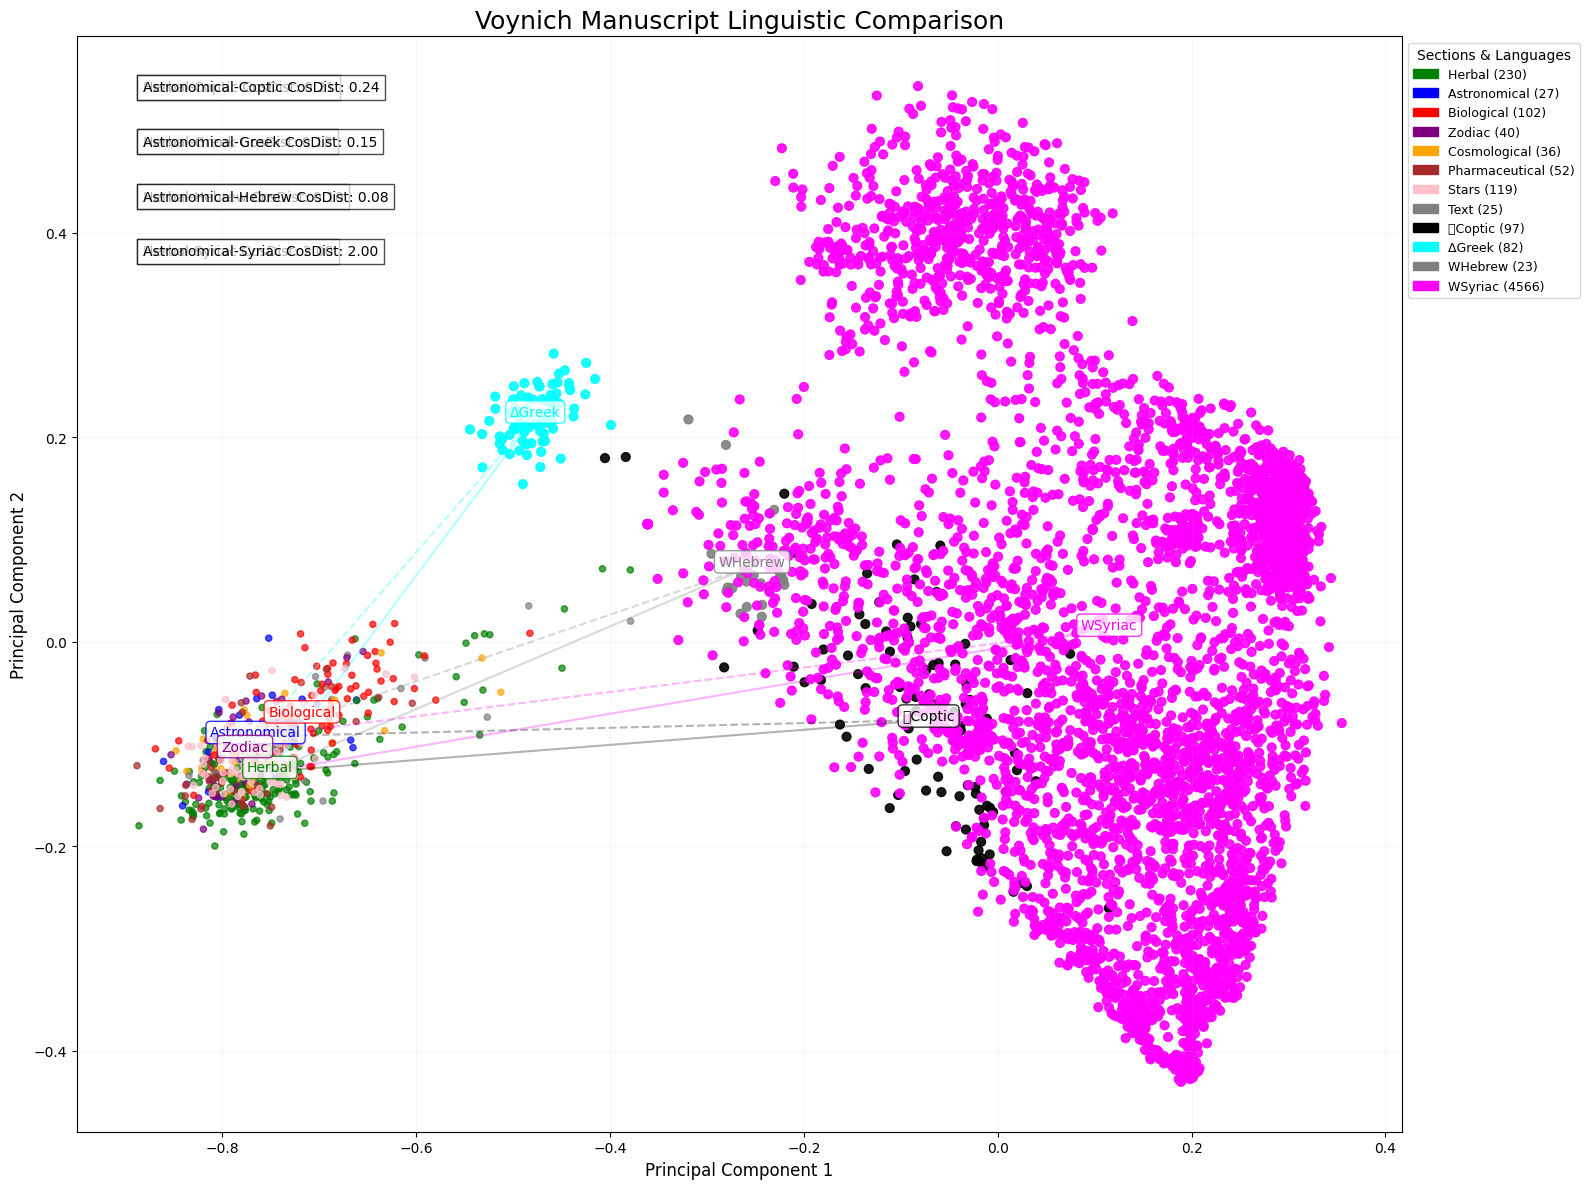

Herbal to Coptic: CosDist=0.6199
Herbal to Greek: CosDist=0.8622
Herbal to Hebrew: CosDist=0.8437
Herbal to Syriac: CosDist=0.7872
Astronomical to Coptic: CosDist=0.6631
Astronomical to Greek: CosDist=0.8236
Astronomical to Hebrew: CosDist=0.7761
Astronomical to Syriac: CosDist=0.6878

===== Closest Voynich Sections to Languages =====

Closest Voynich sections to Coptic:
  - Herbal (cosDist: 0.4991)
  - Biological (cosDist: 0.5038)
  - Herbal (cosDist: 0.5161)

Closest Voynich sections to Greek:
  - Pharmaceutical (cosDist: 0.7066)
  - Pharmaceutical (cosDist: 0.7295)
  - Astronomical (cosDist: 0.7321)

Closest Voynich sections to Hebrew:
  - Text (cosDist: 0.7225)
  - Text (cosDist: 0.7270)
  - Text (cosDist: 0.7329)

Closest Voynich sections to Syriac:
  - Stars (cosDist: 0.6496)
  - Stars (cosDist: 0.6626)
  - Text (cosDist: 0.6657)


In [2]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.neighbors import NearestNeighbors
import matplotlib.patches as mpatches
from collections import Counter
import json
import re
import os

# =====================
# CONFIGURATION SECTION
# =====================
VOYNICH_PATH = r"data\embeddings\voynich_chunks_H_20250727T150741Z.jsonl"

LANGUAGES_CONFIG = {
    "Coptic": {
        "path": r"data\reference_texts\alchemical_corpora\Coptic\language_processed\coptic_chunks_20250727T150738Z.jsonl",
        "color": "black",
        "symbol": "𓆎"
    },
    "Greek": {
        "path": r"data\reference_texts\alchemical_corpora\Greek\language_processed\Hermetica_20250727T152401Z.jsonl",
        "color": "cyan",
        "symbol": "Δ"
    },
    "Hebrew": {
         "path": r"data\reference_texts\alchemical_corpora\Hebrew\language_processed\SeferYetzira_20250727T155303Z.jsonl",
         "color": "gray",
         "symbol": "W"
    },
    "Syriac": {
        "path": r"data\reference_texts\alchemical_corpora\Syriac\language_processed\syriac_corpus_20250727T161033Z.jsonl",
        "color": "magenta",
        "symbol": "W"
    }
}

SECTION_COLORS = {
    'Herbal': 'green', 'Astronomical': 'blue', 'Biological': 'red',
    'Zodiac': 'purple', 'Cosmological': 'orange', 'Pharmaceutical': 'brown',
    'Stars': 'pink', 'Text': 'gray', 'Unknown': 'silver'
}

ZODIAC_MAP = {
    '1': 'Aries', '2': 'Taurus', '3': 'Gemini', '4': 'Cancer',
    '5': 'Leo', '6': 'Virgo', '7': 'Libra', '8': 'Scorpio',
    '9': 'Sagittarius', '10': 'Capricorn', '11': 'Aquarius', '12': 'Pisces'
}

PLOT_SIZE = (16, 12)
PLOT_DPI = 300
OUTPUT_FILENAME = "voynich_language_comparison.png"

# =====================
# FUNCTION DEFINITIONS
# =====================

def load_embeddings(path, source_name):
    records = []
    try:
        if os.path.exists(path):
            with open(path, "r", encoding="utf-8") as f:
                for line in f:
                    try:
                        records.append(json.loads(line))
                    except json.JSONDecodeError:
                        print(f"  JSON decode error in {path}")
            print(f"Loaded {len(records)} records from {source_name}")
        else:
            print(f"File not found: {path}")
    except Exception as e:
        print(f"Error loading {source_name}: {str(e)}")
    return records


def extract_section(metadata):
    if not isinstance(metadata, list):
        return 'Unknown'
    sections = []
    for item in metadata:
        if isinstance(item, dict):
            section = item.get('section')
            if section and isinstance(section, str):
                sections.append(section)
    return Counter(sections).most_common(1)[0][0] if sections else 'Unknown'


def clean_labels(labels):
    cleaned = []
    for label in labels:
        if isinstance(label, str) and label.isdigit():
            cleaned.append(ZODIAC_MAP.get(label, 'Zodiac'))
        elif isinstance(label, str):
            clean_label = re.sub(r'\s+', ' ', label).strip()
            cleaned.append(clean_label)
        else:
            cleaned.append('Unknown')
    return cleaned


def annotate_group(ax, label, color, positions, symbol=""):
    indices = [i for i, lbl in enumerate(cleaned_labels) if lbl == label]
    if indices:
        center = np.mean(positions[indices], axis=0)
        ax.annotate(f"{symbol}{label}", center,
                    fontsize=10, ha='center', color=color,
                    bbox=dict(boxstyle="round,pad=0.3", fc='white', ec=color, alpha=0.8))
        return center
    return None

# =====================
# MAIN PROCESSING
# =====================
print("===== Loading Data =====")
voynich_records = load_embeddings(VOYNICH_PATH, "Voynich")
reference_records = {}
for lang, config in LANGUAGES_CONFIG.items():
    reference_records[lang] = load_embeddings(config["path"], lang)

print("\n===== Preparing Data =====")
all_records = voynich_records.copy()
all_labels, all_sources, all_embeddings = [], [], []

# Voynich
for chunk in voynich_records:
    try:
        section = extract_section(chunk.get('metadata', []))
        all_embeddings.append(chunk["embedding"])
        all_labels.append(section)
        all_sources.append('Voynich')
    except Exception as e:
        print(f"Skipping Voynich chunk: {str(e)}")

# References
for lang, records in reference_records.items():
    for record in records:
        try:
            all_embeddings.append(record["embedding"])
            all_labels.append(lang)
            all_sources.append(lang)
            all_records.append(record)
        except Exception as e:
            print(f"Skipping {lang} record: {str(e)}")

cleaned_labels = clean_labels(all_labels)
label_counter = Counter(cleaned_labels)
print("\nLabel distribution:")
for label, count in label_counter.most_common():
    print(f"- {label}: {count}")

# Prepare arrays
X = np.array(all_embeddings)
# PCA for visualization only
X2d = PCA(n_components=2).fit_transform(X)

print("\n===== Creating Visualization =====")
color_map = SECTION_COLORS.copy()
for lang, config in LANGUAGES_CONFIG.items():
    color_map[lang] = config["color"]
colors = [color_map.get(lbl, 'silver') for lbl in cleaned_labels]
sizes = [20 if src=='Voynich' else 40 for src in all_sources]
alphas = [0.7 if src=='Voynich' else 0.9 for src in all_sources]

fig, ax = plt.subplots(figsize=PLOT_SIZE)
ax.scatter(X2d[:,0], X2d[:,1], c=colors, s=sizes, alpha=alphas)

# Legend
handles = []
for label, color in color_map.items():
    cnt = cleaned_labels.count(label)
    if cnt:
        symbol = LANGUAGES_CONFIG.get(label, {}).get("symbol", "")
        handles.append(mpatches.Patch(color=color, label=f"{symbol}{label} ({cnt})"))
unknown_cnt = cleaned_labels.count('Unknown')
if unknown_cnt:
    handles.append(mpatches.Patch(color='silver', label=f"Unknown ({unknown_cnt})"))
ax.legend(handles=handles, title="Sections & Languages", loc='upper left', bbox_to_anchor=(1,1), fontsize=9)

# Annotations
centers = {}
for lang, conf in LANGUAGES_CONFIG.items():
    centers[lang] = annotate_group(ax, lang, conf["color"], X2d, conf.get("symbol",""))
for section in ['Herbal','Astronomical','Biological','Zodiac']:
    centers[section] = annotate_group(ax, section, SECTION_COLORS.get(section,'silver'), X2d)

# Connections
for section in ['Herbal', 'Astronomical']:
    section_center = centers.get(section)
    if section_center is not None:
        for lang in LANGUAGES_CONFIG:
            lang_center = centers.get(lang)
            if lang_center is not None:
                ls = '-' if section == 'Herbal' else '--'
                ax.plot(
                    [section_center[0], lang_center[0]],
                    [section_center[1], lang_center[1]],
                    color=color_map[lang],
                    linestyle=ls,
                    alpha=0.3,
                    linewidth=1.5
                )

# Distance annotations (cosine distance)
for base in ['Herbal', 'Astronomical']:
    base_center = centers.get(base)
    if base_center is None:
        continue

    for idx, lang in enumerate(LANGUAGES_CONFIG):
        lang_center = centers.get(lang)
        if lang_center is None:
            continue

        # compute cosine distance
        sim = cosine_similarity(
            [base_center],
            [lang_center]
        )[0][0]
        dist = 1 - sim

        ax.text(
            0.05,
            0.95 - 0.05 * idx,
            f"{base}-{lang} CosDist: {dist:.2f}",
            transform=ax.transAxes,
            fontsize=10,
            bbox=dict(facecolor='white', alpha=0.7)
        )


ax.set_title("Voynich Manuscript Linguistic Comparison", fontsize=18)
ax.set_xlabel("Principal Component 1", fontsize=12)
ax.set_ylabel("Principal Component 2", fontsize=12)
ax.grid(alpha=0.1)
plt.tight_layout()
plt.savefig(OUTPUT_FILENAME, dpi=PLOT_DPI, bbox_inches='tight')
print(f"Plot saved as '{OUTPUT_FILENAME}'")
plt.show()

# Helper to compute and print Cosine Distance between two indices
def report_dist(label_a, label_b):
    idx_a = cleaned_labels.index(label_a)
    idx_b = cleaned_labels.index(label_b)
    sim = cosine_similarity([X[idx_a]], [X[idx_b]])[0][0]
    print(f"{label_a} to {label_b}: CosDist={1 - sim:.4f}")

# Herbal
if 'Herbal' in cleaned_labels:
    for lang in LANGUAGES_CONFIG:
        if lang in cleaned_labels:
            report_dist('Herbal', lang)

# Astronomical
if 'Astronomical' in cleaned_labels:
    for lang in LANGUAGES_CONFIG:
        if lang in cleaned_labels:
            report_dist('Astronomical', lang)

print("\n===== Closest Voynich Sections to Languages =====")
for lang in LANGUAGES_CONFIG:
    lang_indices = [i for i,lbl in enumerate(cleaned_labels) if lbl==lang]
    voy_indices = [i for i,src in enumerate(all_sources) if src=='Voynich']
    if lang_indices and voy_indices:
        nn = NearestNeighbors(n_neighbors=3, metric='cosine').fit(X[voy_indices])
        dists, idxs = nn.kneighbors([X[lang_indices[0]]])
        print(f"\nClosest Voynich sections to {lang}:")
        for d,i in zip(dists[0], idxs[0]):
            sec = cleaned_labels[voy_indices[i]]
            print(f"  - {sec} (cosDist: {d:.4f})")


#### Create Similarity Rankings and Prompts Using Cosine Similarity

In [7]:
import json
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.preprocessing import normalize

# Configuration
TOP_N = 10  # Number of closest chunks to save
LLM_N = 10  # Number of chunks to include in LLM prompt
VOYNICH_SOURCE = 'Voynich'

def find_closest_chunks():
    print("\n===== Finding Closest Chunks =====")

    # Get all Voynich indices
    voynich_indices = [i for i, source in enumerate(all_sources) if source == VOYNICH_SOURCE]
    voynich_embeddings = np.array([all_embeddings[i] for i in voynich_indices])

    for lang, config in LANGUAGES_CONFIG.items():
        print(f"\nProcessing {lang}...")

        # Get language indices
        lang_indices = [i for i, source in enumerate(all_sources) if source == lang]
        lang_embeddings = np.array([all_embeddings[i] for i in lang_indices])

        if not voynich_indices or not lang_indices:
            print(f"  Skipping {lang} - missing data")
            continue

        # Normalize embeddings (only if not already normalized)
        voynich_embeddings_norm = normalize(voynich_embeddings)
        lang_embeddings_norm = normalize(lang_embeddings)

        # Compute cosine similarity matrix
        similarity_matrix = cosine_similarity(voynich_embeddings_norm, lang_embeddings_norm)

        # Find top matches
        closest_data = []
        for i, voynich_idx in enumerate(voynich_indices):
            max_idx = np.argmax(similarity_matrix[i])
            max_sim = similarity_matrix[i][max_idx]
            lang_idx = lang_indices[max_idx]

            closest_data.append({
                "voynich_idx": voynich_idx,
                "lang_idx": lang_idx,
                "similarity": max_sim
            })

        # Sort by descending similarity
        closest_data.sort(key=lambda x: x["similarity"], reverse=True)
        top_data = closest_data[:TOP_N]

        # Save to JSONL
        output_file = f"data/processed/top_{TOP_N}_voynich_for_{lang}.jsonl"
        with open(output_file, "w", encoding="utf-8") as f:
            for rank, data in enumerate(top_data, 1):
                record = all_records[data["voynich_idx"]].copy()
                record["ranking"] = rank
                f.write(json.dumps(record, ensure_ascii=False) + "\n")
        print(f"  Saved {output_file}")

        # Prepare LLM prompt
        prepare_llm_prompt(lang, top_data[:LLM_N])

def prepare_llm_prompt(lang, top_data):
    print(f"  Preparing LLM prompt for {lang}...")

    # Extract top chunks
    lang_chunks = []
    voynich_chunks = []

    for data in top_data:
        lang_chunks.append(all_records[data["lang_idx"]]["text"])
        voynich_chunks.append(all_records[data["voynich_idx"]]["text"])

    # Generate prompt
    prompt = f"Compare these patterns from {lang} alchemical texts with Voynich Herbal section:\n\n"

    prompt += f"=== {lang} texts ===\n"
    for i, text in enumerate(lang_chunks, 1):
        prompt += f"\n[{i}] {text[:1000]}...\n"

    prompt += "\n\n=== Voynich Herbal chunks ===\n"
    for i, text in enumerate(voynich_chunks, 1):
        prompt += f"\n[{i}] {text[:1000]}...\n"

    prompt += "\n\nIdentify:\n"
    prompt += "1. Structural similarities (line length, word repetition patterns)\n"
    prompt += "2. Formulaic phrases (prefix/suffix patterns)\n"
    prompt += "3. Positional token distribution"

    # Save to file
    prompt_file = f"data/prompts/llm_prompt_{lang}.txt"
    with open(prompt_file, "w", encoding="utf-8") as f:
        f.write(prompt)
    print(f"  Saved {prompt_file}")

find_closest_chunks()



===== Finding Closest Chunks =====

Processing Coptic...
  Saved data/processed/top_10_voynich_for_Coptic.jsonl
  Preparing LLM prompt for Coptic...
  Saved data/prompts/llm_prompt_Coptic.txt

Processing Greek...
  Saved data/processed/top_10_voynich_for_Greek.jsonl
  Preparing LLM prompt for Greek...
  Saved data/prompts/llm_prompt_Greek.txt

Processing Hebrew...
  Saved data/processed/top_10_voynich_for_Hebrew.jsonl
  Preparing LLM prompt for Hebrew...
  Saved data/prompts/llm_prompt_Hebrew.txt

Processing Syriac...
  Saved data/processed/top_10_voynich_for_Syriac.jsonl
  Preparing LLM prompt for Syriac...
  Saved data/prompts/llm_prompt_Syriac.txt


In [ ]:
from external_api_functions import VoynichContextManager

env_paths = {
    'Greek':  'data/reference_texts/alchemical_corpora/Greek/language_processed/Hermetica_20250727T161004Z.jsonl',
    'Hebrew': 'data/reference_texts/alchemical_corpora/Hebrew/language_processed/SeferYetzira_20250727T161004Z.jsonl',
    'Coptic': 'data/reference_texts/alchemical_corpora/Coptic/language_processed/coptic_chunks_20250727T161001Z.jsonl',
    'Syriac': 'data/reference_texts/alchemical_corpora/Syriac/language_processed/syriac_corpus_20250727T161033Z.jsonl'
}

manager = VoynichContextManager(
    embeddings_path="data/embeddings/voynich_records_with_embeddings_20250727T125656Z.jsonl",
    reference_paths=env_paths,
    processed_path="data/processed/processed_sections.json",
    responses_path="data/responses/responses.jsonl"
)

section_ids = manager.choose_sections(N=2, include_processed=False)

format_instr = (
    "Please return a JSON object with the following keys:\n"
    "- 'token_structure_analysis': observations on structural patterns in tokens "
    "(e.g. prefix/suffix/delimiter organization, character clustering)\n"
    "- 'possible_function': what functional or grammatical role these patterns may play "
    "(e.g. sentence marker, label, connector, emphasis)\n"
    "- 'delimiter_notes': any structural implications of symbols like '=', '-', or repeated characters\n"
    "- 'confidence': a float between 0 and 1 indicating your confidence in the analysis\n\n"
    "Avoid linguistic translations or semantic analogies to known languages unless explicitly structural."
)

payloads = manager.build_payloads(section_ids, format_instr)




In [6]:
import json

for payload in payloads:
    print(f"Analyzing {payload['id']}")
    result = manager.call_openai(prompt=payload['prompt'], model="gpt-4.1")
    print(json.dumps(result, indent=2, ensure_ascii=False))

Analyzing f107v::P
{
  "token_structure_analysis": [
    "Many tokens share recurring substrings, especially at the beginnings and ends (e.g., 'kai' in 'kaisar', 'lkaiin', 'lkal'; 'chey' in 'chey', 'cheey', 'chody').",
    "The token 'otal!kchy' contains an internal delimiter '!', which is unique among the tokens and may indicate a compound or special form.",
    "Several tokens end with 'y' or 'ey' ('olkeeey', 'chey', 'cheey', 'otedy', 'kchy', 'chody'), suggesting a possible suffix or inflectional ending.",
    "There is a tendency for tokens to begin with 'o', 'l', or 'k' (e.g., 'olkeeey', 'otal!kchy', 'lkaiin', 'otedy', 'qokair', 'lkal'), indicating possible prefixes or root markers.",
    "Repetition of characters is observed, notably in 'olkeeey' (triple 'e') and 'lkaiin' (double 'i'), which may serve as length markers, emphasis, or grammatical indicators.",
    "Token length varies from 4 to 9 characters, but most are in the 5-7 character range, suggesting a moderately agglutinat

In [10]:
from external_api_functions import VoynichContextManager

env_paths = {
    'Greek':  'data/reference_texts/alchemical_corpora/Greek/language_processed/Hermetica_20250727T161004Z.jsonl',
    'Hebrew': 'data/reference_texts/alchemical_corpora/Hebrew/language_processed/SeferYetzira_20250727T161004Z.jsonl',
    'Coptic': 'data/reference_texts/alchemical_corpora/Coptic/language_processed/coptic_chunks_20250727T161001Z.jsonl',
    'Syriac': 'data/reference_texts/alchemical_corpora/Syriac/language_processed/syriac_corpus_20250727T161033Z.jsonl'
}

manager = VoynichContextManager(
    embeddings_path="data/embeddings/voynich_records_with_embeddings_20250727T125656Z.jsonl",
    reference_paths=env_paths,
    processed_path="data/processed/processed_sections.json",
    responses_path="data/responses/responses.jsonl"
)


# Optional: estimate token cost before running
cost_estimate = manager.estimate_recursive_cost(rounds=3)
print("Estimated token usage:", cost_estimate)

# Perform recursive refinement over existing responses
refined_theory = manager.recursive_voynich_refinement(
    rounds=3,
    model="gpt-4.1",
    temp=0.2
)




Estimated token usage: {'rounds': 3, 'input_tokens_per_round': 7815, 'estimated_output_tokens_per_round': 7815, 'total_tokens': 46890}

=== RECURSIVE ROUND 1 ===

=== RECURSIVE ROUND 2 ===

=== RECURSIVE ROUND 3 ===


In [11]:
# Print final synthesis result
print("\n=== FINAL THEORY ===\n")
print(refined_theory)


=== FINAL THEORY ===

```json
{
  "updated_hypothesis": "The tokens in the Voynich manuscript are structured, modular units that follow a consistent internal logic reminiscent of agglutinative or inflectional languages, but are likely part of a constructed or ciphered system. Tokens are composed of a root or stem (often 2-4 characters), optional prefixes and/or suffixes (frequently recurring), and sometimes terminate with a delimiter (notably '='). The delimiter '=' functions as a section or header marker, separating labels or grammatical units from subsequent content, similar to a heading or field name in structured data. Suffixes such as '-aiin', '-ol', '-y', and '-in' are frequent and may serve as grammatical markers (e.g., case, number, or function words), while certain prefixes (e.g., 'ke-', 'cho-', 'pch-') may indicate categories, roles, or inflection. The high repetition of certain endings and the presence of initial consonant clusters suggest a system of morphological marking,

#### Calling the LLM to summarize Hypothesis

In [ ]:
import json
from external_api_functions import VoynichContextManager

env_paths = {
    'Greek':  'data/reference_texts/alchemical_corpora/Greek/language_processed/Hermetica_20250727T161004Z.jsonl',
    'Hebrew': 'data/reference_texts/alchemical_corpora/Hebrew/language_processed/SeferYetzira_20250727T161004Z.jsonl',
    'Coptic': 'data/reference_texts/alchemical_corpora/Coptic/language_processed/coptic_chunks_20250727T161001Z.jsonl',
    'Syriac': 'data/reference_texts/alchemical_corpora/Syriac/language_processed/syriac_corpus_20250727T161033Z.jsonl'
}

manager = VoynichContextManager(
    embeddings_path="data/embeddings/voynich_records_with_embeddings_20250727T125656Z.jsonl",
    reference_paths=env_paths,
    processed_path="processed_sections.json",
    responses_path="data/responses/responses.jsonl"
)

summary = manager.summarize_all_responses(model="gpt-4.1", temperature=0.5)
print(json.dumps(summary, indent=2, ensure_ascii=False))

NameError: name 'json' is not defined

In [3]:
import json
print(json.dumps(summary, indent=2, ensure_ascii=False))

{
  "summary_hypothesis": "The Voynich manuscript employs a highly structured, modular writing system in which tokens are constructed from roots, prefixes, and suffixes, frequently terminated by a distinctive delimiter (most often '='). These tokens serve as grammatical or structural units—such as headers, labels, or inflected words—rather than direct lexical items from known languages. Recurring suffixes (e.g., '-aiin', '-y', '-ol', '-in') and initial clusters/prefixes (e.g., 'ke-', 'cho-', 'pch-') indicate a system of agglutination or inflection, encoding grammatical or semantic roles such as case, number, or category. The delimiter '=' consistently marks the end of a token, functioning as a section or field boundary, analogous to a header or label in structured data, and is not used as an internal separator. Statistical and embedding analyses show fluctuating similarity to Syriac, Coptic, and Greek, but the lack of direct lexical matches and the unique structural logic suggest the s

#### Renders the answer to a .docx file

In [5]:
from render_to_docx import render_summary_to_docx


render_summary_to_docx(summary, "data/processed/voynich_summary.docx")

Document saved to data/processed/voynich_summary.docx
